# Model VGGNet and FCN Define and setup as Extractor and Decoder
## Breast-Ultrasound-Segmentation

## About Dataset
Breast cancer is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths. The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes: normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

### Data
The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

If you use this dataset, please cite:
Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

## Imports

In [1]:
import os

import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

if os.getenv("DATA_ROOT") is None:
    os.environ["DATA_ROOT"] = f"{root}/data"

In [2]:
import torch

# Setup device-agnostic code
if torch.cuda.is_available():
    DEVICE = "cuda"  # NVIDIA GPU
    print("GPU Found!!")
else:
    raise Exception("No GPU Found!!")

GPU Found!!


In [3]:
import hydra
from hydra import compose, initialize

In [4]:
# # auto reload dotenv
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths setup

In [5]:
from omegaconf import DictConfig

with initialize(config_path="../configs", job_name="training_setup", version_base=None):
    cfg: DictConfig = compose(config_name="train.yaml")
    # print(OmegaConf.to_yaml(cfg))
    print(cfg.paths)

{'root_dir': '${oc.env:PROJECT_ROOT}', 'root_data_dir': '${oc.env:DATA_ROOT}', 'log_dir': '${paths.root_dir}/logs/', 'output_dir': '${hydra:runtime.output_dir}', 'work_dir': '${hydra:runtime.cwd}'}


In [6]:
os.chdir(root)

## Loading Dataset

In [7]:
data_module = hydra.utils.instantiate(cfg.datamodule)
train_dl = data_module.train_dataloader()
val_dl = data_module.val_dataloader()

In [8]:
for images, targets in train_dl:
    break
print(images.shape, targets["masks"].shape, targets["labels"].shape)

print(f"images:{images.dtype}, {images[0].min()}, {images[0].max()}")
print(f'masks {targets["masks"].dtype}, {targets["masks"][0].min()}, {targets["masks"][0].max()}')
print(
    f'labels {targets["labels"].dtype}, {targets["labels"][0].min()}, {targets["labels"][0].max()}'
)

torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256]) torch.Size([32, 3])
images:torch.float32, 0.0, 0.988235354423523
masks torch.uint8, 0, 255
labels torch.float32, 0.0, 1.0


In [9]:
for _images, _targets in val_dl:
    break
print(_images.shape, _targets["masks"].shape, _targets["labels"].shape)

print(f"images:{_images[0].dtype}, {_images[0].min()}, {_images[0].max()}")
print(f'masks {_targets["masks"].dtype}, {_targets["masks"].min()}, {_targets["masks"].max()}')
print(f'labels {_targets["labels"].dtype}, {_targets["labels"].min()}, {_targets["labels"].max()}')

torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256]) torch.Size([32, 3])
images:torch.float32, 0.0, 0.9764706492424011
masks torch.uint8, 0, 255
labels torch.float32, 0.0, 1.0


## VGG-16 as feature extractor and FCN-8 as network upsampling and generating the predictions

### Define VGG-16
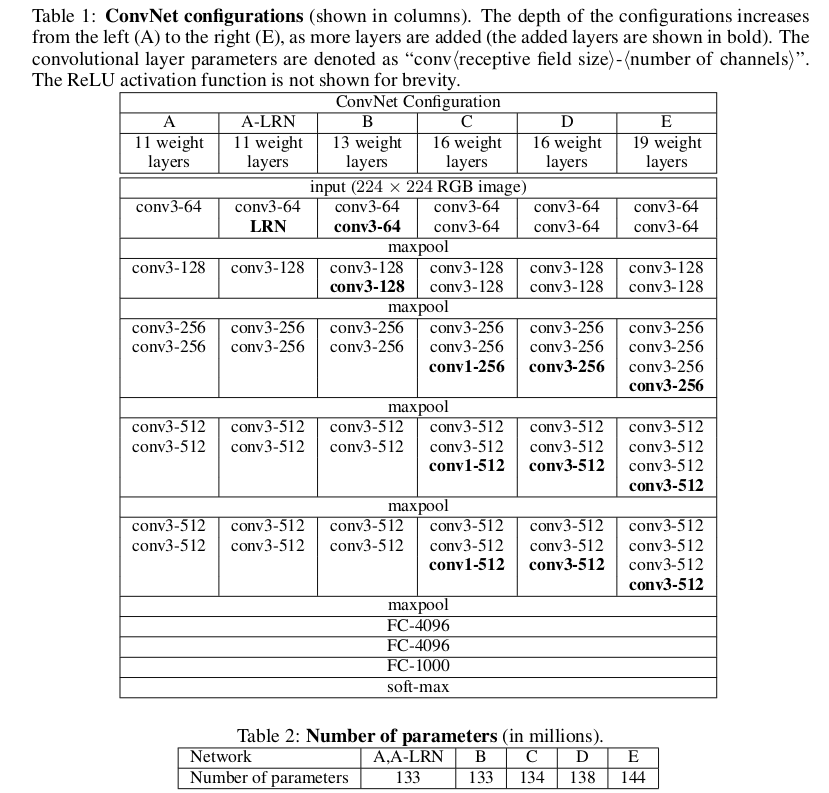

In [10]:
import torch.nn as nn


class VGGNet(nn.Module):
    def __init__(
        self, input_shape: tuple = (3, 256, 256), num_classes: int = 3, vgg_type: str = "vgg19"
    ):
        super().__init__()
        self.vgg_types = {
            "vgg11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
            "vgg13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
            "vgg16": [
                64,
                64,
                "M",
                128,
                128,
                "M",
                256,
                256,
                256,
                "M",
                512,
                512,
                512,
                "M",
                512,
                512,
                512,
                "M",
            ],
            "vgg19": [
                64,
                64,
                "M",
                128,
                128,
                "M",
                256,
                256,
                256,
                256,
                "M",
                512,
                512,
                512,
                512,
                "M",
                512,
                512,
                512,
                512,
                "M",
            ],
        }
        self.in_channels = input_shape[0]
        self._conv_layers = self._create_conv_layers(self.vgg_types[vgg_type])
        # Determine the output shape of the convolutional layers automatically
        with torch.no_grad():
            dummy_input = torch.randn(1, self.in_channels, input_shape[1], input_shape[2])
            output = self._conv_layers(dummy_input)

            # output.size - [32,512,4,4]
            # output.view(output.size(0), -1).shape - [32, 512*4*4] (-1 mean use all elements/flatten)
            self.flattened_size = output.view(output.size(0), -1).shape[1]

        self._classifier = nn.Sequential(
            nn.Linear(in_features=self.flattened_size, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

    def _create_conv_layers(self, architecture) -> nn.Sequential:
        layers = []
        in_channels = self.in_channels
        for x in architecture:
            if x == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels=in_channels, out_channels=x, kernel_size=3, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU(inplace=True),
                ]
                in_channels = x
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)

    def forward(self, x) -> torch.Tensor:
        x = self._conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self._classifier(x)
        return x

In [11]:
input_tensor = torch.randn(1, 1, 224, 224)  # Example input (batch_size, channels, height, width)
vggnet11_model = VGGNet(input_shape=input_tensor.shape[1:], num_classes=3, vgg_type="vgg11")
output = vggnet11_model(input_tensor)

In [12]:
from torchinfo import summary

batch_size = 16
summary(vggnet11_model, input_size=(batch_size, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [16, 3]                   --
├─Sequential: 1-1                        [16, 512, 3, 3]           --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        640
│    └─BatchNorm2d: 2-2                  [16, 64, 224, 224]        128
│    └─ReLU: 2-3                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-4                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-5                       [16, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-6                  [16, 128, 112, 112]       256
│    └─ReLU: 2-7                         [16, 128, 112, 112]       --
│    └─MaxPool2d: 2-8                    [16, 128, 56, 56]         --
│    └─Conv2d: 2-9                       [16, 256, 56, 56]         295,168
│    └─BatchNorm2d: 2-10                 [16, 256, 56, 56]         512
│    └─ReLU: 2-11                        [16, 256, 56, 56]         --
│ 

In [ ]:
vggnet13_model = VGGNet(input_shape=input_tensor.shape[1:], num_classes=3, vgg_type="vgg13")
output = vggnet13_model(input_tensor)
summary(vggnet13_model, input_size=(batch_size, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [16, 3]                   --
├─Sequential: 1-1                        [16, 512, 3, 3]           --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        640
│    └─BatchNorm2d: 2-2                  [16, 64, 224, 224]        128
│    └─ReLU: 2-3                         [16, 64, 224, 224]        --
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [16, 64, 224, 224]        128
│    └─ReLU: 2-6                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [16, 128, 112, 112]       256
│    └─ReLU: 2-10                        [16, 128, 112, 112]       --
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147,58

In [14]:
vggnet16_model = VGGNet(input_shape=input_tensor.shape[1:], num_classes=3, vgg_type="vgg16")
output = vggnet16_model(input_tensor)
summary(vggnet16_model, input_size=(batch_size, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [16, 3]                   --
├─Sequential: 1-1                        [16, 512, 3, 3]           --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        640
│    └─BatchNorm2d: 2-2                  [16, 64, 224, 224]        128
│    └─ReLU: 2-3                         [16, 64, 224, 224]        --
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [16, 64, 224, 224]        128
│    └─ReLU: 2-6                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [16, 128, 112, 112]       256
│    └─ReLU: 2-10                        [16, 128, 112, 112]       --
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147,58

In [15]:
vggnet19_model = VGGNet(input_shape=input_tensor.shape[1:], num_classes=3, vgg_type="vgg19")
output = vggnet19_model(input_tensor)
summary(vggnet19_model, input_size=(batch_size, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [16, 3]                   --
├─Sequential: 1-1                        [16, 512, 3, 3]           --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        640
│    └─BatchNorm2d: 2-2                  [16, 64, 224, 224]        128
│    └─ReLU: 2-3                         [16, 64, 224, 224]        --
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [16, 64, 224, 224]        128
│    └─ReLU: 2-6                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [16, 128, 112, 112]       256
│    └─ReLU: 2-10                        [16, 128, 112, 112]       --
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147,58

In [16]:
from src.models.components.nets.vanilla_vggnet_feature_extractor import (
    VanillaVGGNetFeatureExtractor,
)

vanilla_vggnet_model = VanillaVGGNetFeatureExtractor(
    input_shape=input_tensor.shape[1:], vgg_type="vgg19"
)
output = vanilla_vggnet_model(input_tensor)
summary(vanilla_vggnet_model, input_size=(batch_size, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VanillaVGGNetFeatureExtractor            [16, 64, 112, 112]        --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        640
│    └─BatchNorm2d: 2-2                  [16, 64, 224, 224]        128
│    └─ReLU: 2-3                         [16, 64, 224, 224]        --
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [16, 64, 224, 224]        128
│    └─ReLU: 2-6                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [16, 128, 112, 112]       256
│    └─ReLU: 2-10                        [16, 128, 112, 112]       --
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147,58

In [17]:
layers = vanilla_vggnet_model._conv_layers
for layer in layers:
    # x = layer(x)
    if isinstance(layer, nn.MaxPool2d):
        print(layer)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [18]:
len(layers), len(output)

(54, 6)

## Pretrained VGGNet

In [19]:
import torch
import torch.nn as nn
from torchvision import models


class VGGNetEncoder(nn.Module):
    def __init__(
        self,
        pretrained_weights: str | None = "DEFAULT",
        num_classes: int = 3,
        model: str = "vgg11",
        requires_grad: bool = True,
        remove_fc: bool = True,
        show_params: bool = False,
    ):
        super().__init__()
        self.model_name = model
        self.num_classes = num_classes
        # Create a dictionary mapping model names to model constructors
        vgg_models = {
            "vgg11": models.vgg11,
            "vgg11_bn": models.vgg11_bn,
            "vgg13": models.vgg13,
            "vgg13_bn": models.vgg13_bn,
            "vgg16": models.vgg16,
            "vgg16_bn": models.vgg16_bn,
            "vgg19": models.vgg19,
            "vgg19_bn": models.vgg19_bn,
        }
        # Check if the model is supported
        if model not in vgg_models:
            raise ValueError(f"Unsupported VGG model: {model}")

        # Load the requested model

        if pretrained_weights:
            self.vgg = vgg_models[model](weights=pretrained_weights)
        else:
            self.vgg = vgg_models[model]()

        if not requires_grad:
            for param in self.model.parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.vgg.classifier

        # Dynamically find the indices of MaxPool2d layers
        self.pool_indices = []
        for i, layer in enumerate(self.vgg.features):
            if isinstance(layer, nn.MaxPool2d):
                self.pool_indices.append(i)

        if show_params:
            print(f"Pool indices for {model}: {self.pool_indices}")
            for i, layer in enumerate(self.vgg.features):
                print(f"Layer {i}: {layer}")

        # number of filters for the output convolutional layers
        self.final_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=7, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=4096, out_channels=4096, kernel_size=1, padding="same"),
            nn.ReLU(inplace=True),
        )

    def forward(self, x) -> dict[str, torch.Tensor]:
        features = {}

        # Process each layer and store the output after each MaxPool2d
        for i, layer in enumerate(self.vgg.features):
            x = layer(x)
            if i in self.pool_indices:
                pool_idx = self.pool_indices.index(i) + 1
                features[f"pool{pool_idx}"] = x
        # input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
        # we can extract more features by chaining two more convolution layers.
        features["pool5"] = self.final_conv(x)
        print(f"pool5 shape {features['pool5'].shape}")

        return features

In [20]:
vgg_encoder = VGGNetEncoder(pretrained_weights="DEFAULT", model="vgg11")
input_tensor = torch.randn(1, 3, 224, 224)  # Example input
outputs = vgg_encoder(input_tensor)

# outputs will be a list of 5 tensors, each representing the output of a max-pooling layer
for i, output in enumerate(outputs.values()):
    print(f"Output from max-pooling layer {i+1}: {output.shape}")

pool5 shape torch.Size([1, 4096, 7, 7])
Output from max-pooling layer 1: torch.Size([1, 64, 112, 112])
Output from max-pooling layer 2: torch.Size([1, 128, 56, 56])
Output from max-pooling layer 3: torch.Size([1, 256, 28, 28])
Output from max-pooling layer 4: torch.Size([1, 512, 14, 14])
Output from max-pooling layer 5: torch.Size([1, 4096, 7, 7])


## Setup Fully Convolution Neural Network (FCN)

## FCN32

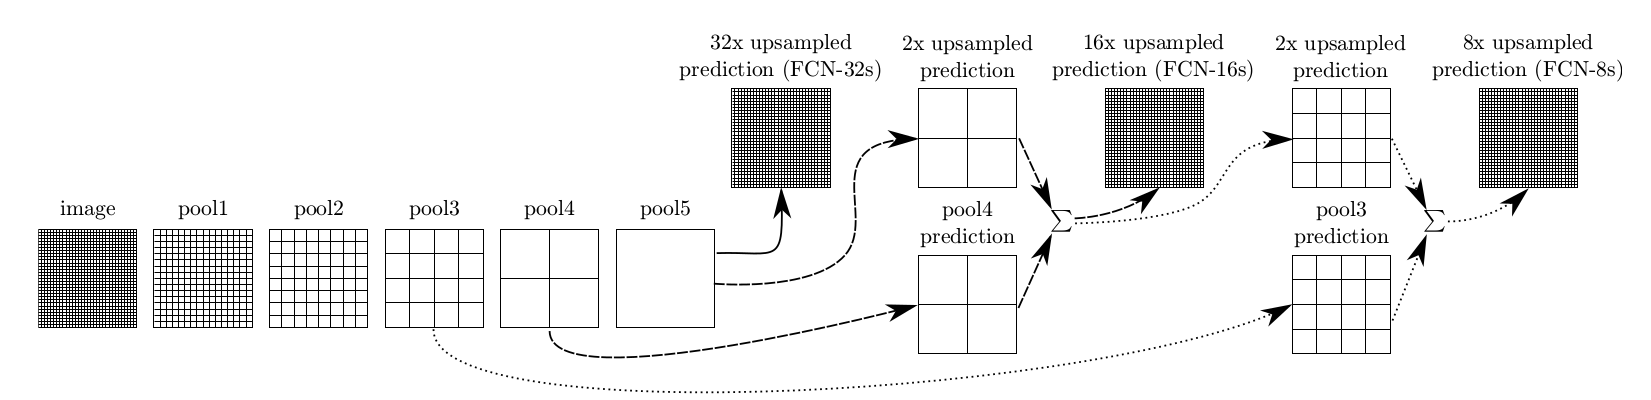

In [21]:
class FCN32Decoder(nn.Module):
    def __init__(self, encoder: nn.Module, num_classes: int = 3):
        super().__init__()
        self.encoder = encoder
        self.num_classes = num_classes
        self.upsample_0 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=4096,
                out_channels=num_classes,
                stride=32,
                kernel_size=4,
                padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(-1),  # Remove 1 pixel from each side
        )

    def forward(self, x):
        encoder = self.encoder(x)
        x = self.upsample_0(encoder["pool5"])
        return x

In [22]:
batch_size, n_class, h, w = 32, 3, 224, 224
encoder = VGGNetEncoder(pretrained_weights="DEFAULT", num_classes=n_class)
fcn = FCN32Decoder(encoder=encoder, num_classes=n_class)

input = torch.autograd.Variable(torch.randn(batch_size, 3, 224, 224))
output = fcn(input)
output.shape

pool5 shape torch.Size([32, 4096, 7, 7])


torch.Size([32, 3, 192, 192])

In [23]:
# assert output.size() == torch.Size([batch_size, n_class, h, w])

## FCN16 - Decoder

In [24]:
class FCN16Decoder(nn.Module):
    def __init__(self, encoder: nn.Module, num_classes: int = 3):
        super().__init__()
        self.encoder = encoder
        self.num_classes = num_classes
        self.upsample_0 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=4096,
                out_channels=num_classes,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
        )
        self.upsample_1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=num_classes,
                out_channels=num_classes,
                stride=16,
                kernel_size=8,
                padding=4,
                output_padding=0,
                bias=False,
            ),
        )
        self.conv1 = nn.Conv2d(in_channels=512, out_channels=self.num_classes, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        encoder = self.encoder(x)
        pool5 = encoder["pool5"]
        pool4 = encoder["pool4"]
        print(f"pool5 shape: {pool5.shape}")
        print(f"pool4 shape: {pool4.shape}")
        x5 = self.upsample_0(pool5)
        print(f"x5 shape: {x5.shape}")
        # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `x5` above
        x4 = self.relu(self.conv1(pool4))
        print(f"x4 shape: {x4.shape}")
        x = x5 + x4

        x = self.upsample_1(x)
        return x

In [25]:
from torchinfo import summary

batch_size, n_class, h, w = 2, 3, 224, 224  # Standard VGG input size

# Create models
encoder = VGGNetEncoder(pretrained_weights="DEFAULT", num_classes=n_class)
fcn = FCN16Decoder(encoder=encoder, num_classes=n_class)

# Test input
input_tensor = torch.autograd.Variable(torch.randn(batch_size, 3, 224, 224))
output = fcn(input_tensor)


summary(fcn, input_size=(batch_size, 3, 224, 224))

pool5 shape torch.Size([2, 4096, 7, 7])
pool5 shape: torch.Size([2, 4096, 7, 7])
pool4 shape: torch.Size([2, 512, 14, 14])
x5 shape: torch.Size([2, 3, 14, 14])
x4 shape: torch.Size([2, 3, 14, 14])
pool5 shape torch.Size([2, 4096, 7, 7])
pool5 shape: torch.Size([2, 4096, 7, 7])
pool4 shape: torch.Size([2, 512, 14, 14])
x5 shape: torch.Size([2, 3, 14, 14])
x4 shape: torch.Size([2, 3, 14, 14])


Layer (type:depth-idx)                   Output Shape              Param #
FCN16Decoder                             [2, 3, 208, 208]          --
├─VGGNetEncoder: 1-1                     [2, 4096, 7, 7]           --
│    └─VGG: 2-1                          --                        --
│    │    └─Sequential: 3-1              --                        9,220,480
│    └─Sequential: 2-2                   [2, 4096, 7, 7]           --
│    │    └─Conv2d: 3-2                  [2, 4096, 7, 7]           102,764,544
│    │    └─ReLU: 3-3                    [2, 4096, 7, 7]           --
│    │    └─Conv2d: 3-4                  [2, 4096, 7, 7]           16,781,312
│    │    └─ReLU: 3-5                    [2, 4096, 7, 7]           --
├─Sequential: 1-2                        [2, 3, 14, 14]            --
│    └─ConvTranspose2d: 2-3              [2, 3, 14, 14]            110,592
├─Conv2d: 1-3                            [2, 3, 14, 14]            1,539
├─ReLU: 1-4                              [2, 3, 14, 1

In [26]:
# Verify output
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output.shape}")
assert output.shape == (
    batch_size,
    n_class,
    h,
    w,
), f"Expected {(batch_size, n_class, h, w)}, got {output.shape}"

Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 3, 208, 208])


AssertionError: Expected (2, 3, 224, 224), got torch.Size([2, 3, 208, 208])

![image.png](attachment:image.png)

In [39]:
class FCN8Decoder(nn.Module):
    def __init__(self, encoder: nn.Module, num_classes: int = 3):
        super().__init__()
        self.encoder = encoder
        self.num_classes = num_classes
        self.upsample_5 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=4096,
                out_channels=512,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
        )
        self.bn5 = nn.BatchNorm2d(512)
        self.upsample_4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512,
                out_channels=256,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
        )
        self.bn4 = nn.BatchNorm2d(256)

        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=128,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )

        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x) -> torch.Tensor:
        encoder = self.encoder(x)
        pool5 = encoder["pool5"]
        pool4 = encoder["pool4"]
        pool3 = encoder["pool3"]
        print(f"in pool5 shape: {pool5.shape}")
        print(f"in pool4 shape: {pool4.shape}")

        # First upsampling + skip connection with pool4
        upsampled_5 = self.upsample_5(pool5)
        print(f"upsampled_5 shape: {upsampled_5.shape}")

        x4 = self.bn5(upsampled_5 + pool4)
        print(f"x4 shape: {x4.shape}")

        # Second upsampling + skip connection with pool3
        #  # upsample the resulting tensor of the operation you just did
        upsample_4 = self.upsample_4(x4)

        # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
        x3 = self.bn4(upsample_4 + pool3)
        print(f"x3 shape: {x3.shape}")

        # Progressive upsampling to original image size
        score = self.upsample3(x3)
        score = self.upsample2(score)
        score = self.upsample1(score)

        return self.classifier(score)

In [40]:
from torchinfo import summary

batch_size, n_class, h, w = 2, 3, 224, 224  # Standard VGG input size

# Create models
encoder = VGGNetEncoder(pretrained_weights="DEFAULT", num_classes=n_class)
fcn = FCN8Decoder(encoder=encoder, num_classes=n_class)

# Test input
test_input = torch.randn(batch_size, 3, 224, 224)
input_tensor = torch.autograd.Variable(test_input)
output = fcn(input_tensor)


summary(fcn, input_size=(batch_size, n_class, h, w))

pool5 shape torch.Size([2, 4096, 7, 7])
in pool5 shape: torch.Size([2, 4096, 7, 7])
in pool4 shape: torch.Size([2, 512, 14, 14])
upsampled_5 shape: torch.Size([2, 512, 14, 14])
x4 shape: torch.Size([2, 512, 14, 14])
x3 shape: torch.Size([2, 256, 28, 28])
pool5 shape torch.Size([2, 4096, 7, 7])
in pool5 shape: torch.Size([2, 4096, 7, 7])
in pool4 shape: torch.Size([2, 512, 14, 14])
upsampled_5 shape: torch.Size([2, 512, 14, 14])
x4 shape: torch.Size([2, 512, 14, 14])
x3 shape: torch.Size([2, 256, 28, 28])


Layer (type:depth-idx)                   Output Shape              Param #
FCN8Decoder                              [2, 3, 224, 224]          --
├─VGGNetEncoder: 1-1                     [2, 4096, 7, 7]           --
│    └─VGG: 2-1                          --                        --
│    │    └─Sequential: 3-1              --                        9,220,480
│    └─Sequential: 2-2                   [2, 4096, 7, 7]           --
│    │    └─Conv2d: 3-2                  [2, 4096, 7, 7]           102,764,544
│    │    └─ReLU: 3-3                    [2, 4096, 7, 7]           --
│    │    └─Conv2d: 3-4                  [2, 4096, 7, 7]           16,781,312
│    │    └─ReLU: 3-5                    [2, 4096, 7, 7]           --
├─Sequential: 1-2                        [2, 512, 14, 14]          --
│    └─ConvTranspose2d: 2-3              [2, 512, 14, 14]          18,874,368
│    └─ReLU: 2-4                         [2, 512, 14, 14]          --
├─BatchNorm2d: 1-3                       [2, 512, 14,

In [41]:
# Verify output
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output.shape}")
assert output.shape == (
    batch_size,
    n_class,
    224,
    224,
), f"Expected {(batch_size, n_class, h, w)}, got {output.shape}"

Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 3, 224, 224])


## Progressive scaling for smoother resutls

In [42]:
class FCN8Decoder(nn.Module):
    def __init__(self, encoder: nn.Module, num_classes: int = 3):
        super().__init__()
        self.encoder = encoder
        self.num_classes = num_classes
        self.upsample_5 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=4096,
                out_channels=512,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
        )
        self.bn5 = nn.BatchNorm2d(512)
        self.upsample_4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512,
                out_channels=256,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
        )
        self.bn4 = nn.BatchNorm2d(256)

        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=128,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )

        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x) -> torch.Tensor:
        encoder = self.encoder(x)
        pool5 = encoder["pool5"]
        pool4 = encoder["pool4"]
        pool3 = encoder["pool3"]
        print(f"in pool5 shape: {pool5.shape}")
        print(f"in pool4 shape: {pool4.shape}")

        # First upsampling + skip connection with pool4
        upsampled_5 = self.upsample_5(pool5)
        print(f"upsampled_5 shape: {upsampled_5.shape}")

        x4 = self.bn5(upsampled_5 + pool4)
        print(f"x4 shape: {x4.shape}")

        # Second upsampling + skip connection with pool3
        #  # upsample the resulting tensor of the operation you just did
        upsample_4 = self.upsample_4(x4)

        # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
        x3 = self.bn4(upsample_4 + pool3)
        print(f"x3 shape: {x3.shape}")

        # Progressive upsampling to original image size
        score = self.upsample3(x3)
        score = self.upsample2(score)
        score = self.upsample1(score)

        return self.classifier(score)

In [43]:
from torchinfo import summary

batch_size, n_class, h, w = 2, 3, 224, 224  # Standard VGG input size

# Create models
encoder = VGGNetEncoder(pretrained_weights="DEFAULT", num_classes=n_class)
fcn8 = FCN8Decoder(encoder=encoder, num_classes=n_class)

# Test input
test_input = torch.randn(batch_size, 3, 224, 224)
input_tensor = torch.autograd.Variable(test_input)
output = fcn8(input_tensor)


summary(fcn8, input_size=(batch_size, n_class, h, w))

pool5 shape torch.Size([2, 4096, 7, 7])
in pool5 shape: torch.Size([2, 4096, 7, 7])
in pool4 shape: torch.Size([2, 512, 14, 14])
upsampled_5 shape: torch.Size([2, 512, 14, 14])
x4 shape: torch.Size([2, 512, 14, 14])
x3 shape: torch.Size([2, 256, 28, 28])
pool5 shape torch.Size([2, 4096, 7, 7])
in pool5 shape: torch.Size([2, 4096, 7, 7])
in pool4 shape: torch.Size([2, 512, 14, 14])
upsampled_5 shape: torch.Size([2, 512, 14, 14])
x4 shape: torch.Size([2, 512, 14, 14])
x3 shape: torch.Size([2, 256, 28, 28])


Layer (type:depth-idx)                   Output Shape              Param #
FCN8Decoder                              [2, 3, 224, 224]          --
├─VGGNetEncoder: 1-1                     [2, 4096, 7, 7]           --
│    └─VGG: 2-1                          --                        --
│    │    └─Sequential: 3-1              --                        9,220,480
│    └─Sequential: 2-2                   [2, 4096, 7, 7]           --
│    │    └─Conv2d: 3-2                  [2, 4096, 7, 7]           102,764,544
│    │    └─ReLU: 3-3                    [2, 4096, 7, 7]           --
│    │    └─Conv2d: 3-4                  [2, 4096, 7, 7]           16,781,312
│    │    └─ReLU: 3-5                    [2, 4096, 7, 7]           --
├─Sequential: 1-2                        [2, 512, 14, 14]          --
│    └─ConvTranspose2d: 2-3              [2, 512, 14, 14]          18,874,368
│    └─ReLU: 2-4                         [2, 512, 14, 14]          --
├─BatchNorm2d: 1-3                       [2, 512, 14,

In [44]:
# Verify output
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output.shape}")
assert output.shape == (
    batch_size,
    n_class,
    224,
    224,
), f"Expected {(batch_size, n_class, h, w)}, got {output.shape}"

Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 3, 224, 224])


In [45]:
class FCN16Decoder(nn.Module):
    def __init__(self, encoder: nn.Module, num_classes: int = 3):
        super().__init__()
        self.encoder = encoder
        self.num_classes = num_classes
        self.upsample_5 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=4096,
                out_channels=512,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
        )

        self.bn5 = nn.BatchNorm2d(512)
        self.upsample_4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512,
                out_channels=256,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )

        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=128,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )

        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                stride=2,
                kernel_size=3,
                padding=1,
                output_padding=1,
                bias=False,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x) -> torch.Tensor:
        encoder = self.encoder(x)
        pool5 = encoder["pool5"]
        pool4 = encoder["pool4"]
        print(f"in pool5 shape: {pool5.shape}")
        print(f"in pool4 shape: {pool4.shape}")

        # First upsampling + skip connection with pool4
        upsampled_5 = self.upsample_5(pool5)
        print(f"upsampled_5 shape: {upsampled_5.shape}")

        x4 = self.bn5(upsampled_5 + pool4)
        print(f"x4 shape: {x4.shape}")

        # Second upsampling + skip connection with pool3
        #  # upsample the resulting tensor of the operation you just did
        upsample_4 = self.upsample_4(x4)
        print(f"x3 shape: {upsample_4.shape}")

        # Progressive upsampling to original image size
        score = self.upsample3(upsample_4)
        score = self.upsample2(score)
        score = self.upsample1(score)

        return self.classifier(score)

In [52]:
encoder = VGGNetEncoder(pretrained_weights="DEFAULT", num_classes=n_class)
_fcn16 = FCN16Decoder(encoder=encoder, num_classes=n_class)

# Test input
test_input = torch.randn(1, 3, 224, 224)

output = _fcn16(test_input)

pool5 shape torch.Size([1, 4096, 7, 7])
in pool5 shape: torch.Size([1, 4096, 7, 7])
in pool4 shape: torch.Size([1, 512, 14, 14])
upsampled_5 shape: torch.Size([1, 512, 14, 14])
x4 shape: torch.Size([1, 512, 14, 14])
x3 shape: torch.Size([1, 256, 28, 28])


In [ ]:
summary(_fcn16, input_size=(batch_size, n_class, h, w))

pool5 shape torch.Size([2, 4096, 7, 7])
in pool5 shape: torch.Size([2, 4096, 7, 7])
in pool4 shape: torch.Size([2, 512, 14, 14])
upsampled_5 shape: torch.Size([2, 512, 14, 14])
x4 shape: torch.Size([2, 512, 14, 14])
x3 shape: torch.Size([2, 256, 28, 28])


Layer (type:depth-idx)                   Output Shape              Param #
FCN16Decoder                             [2, 3, 224, 224]          --
├─VGGNetEncoder: 1-1                     [2, 4096, 7, 7]           --
│    └─VGG: 2-1                          --                        --
│    │    └─Sequential: 3-1              --                        9,220,480
│    └─Sequential: 2-2                   [2, 4096, 7, 7]           --
│    │    └─Conv2d: 3-2                  [2, 4096, 7, 7]           102,764,544
│    │    └─ReLU: 3-3                    [2, 4096, 7, 7]           --
│    │    └─Conv2d: 3-4                  [2, 4096, 7, 7]           16,781,312
│    │    └─ReLU: 3-5                    [2, 4096, 7, 7]           --
├─Sequential: 1-2                        [2, 512, 14, 14]          --
│    └─ConvTranspose2d: 2-3              [2, 512, 14, 14]          18,874,368
│    └─ReLU: 2-4                         [2, 512, 14, 14]          --
├─BatchNorm2d: 1-3                       [2, 512, 14,